# **Importing Libraries**

In [109]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, classification_report, precision_score, f1_score, accuracy_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# **Machine Learning**

In [110]:
df_ml =pd.read_csv('Covid Data Cleaned.csv')

### As we have seen above there is no imbance in the data. So we will not do any sampling.

# **Preprocessing**


In [111]:
# droping unnecessary columns
df_ml.drop(['dead_year', 'dead_month', 'pregnant'], axis=1, inplace=True)

In [112]:
# converting the y
df_ml.classification = df_ml.classification.map({'Not diagnosed':0, 'Diagnosed':1})
df_ml.classification

0         1
1         0
2         1
3         0
4         1
         ..
219217    0
219218    0
219219    0
219220    0
219221    0
Name: classification, Length: 219222, dtype: int64

In [113]:
# spliting data into train and test
X = df_ml.drop('classification', axis=1)
y = df_ml['classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
# builiding pipeline and column transformer
num_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

cat_pipe = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, ['age']),
    ('cat', cat_pipe, ['gender', 'patient_type', 'pneumonia', 'diabetes', 'copd', 'asthma',
       'inmsupr', 'hypertension', 'other_disease', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco', 'dead'])])

In [115]:
# converting X_train and X_test
X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=X_train.columns)
X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test), columns=X_test.columns)

In [116]:
# making training set
training_set = pd.concat([X_train_preprocessed, y_train.reset_index()], axis=1)
training_set.drop('index', axis=1, inplace=True)
training_set

,gender,patient_type,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,dead,classification
0,0.704082,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,0.642857,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0
2,0.500000,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1
3,0.602041,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1
4,0.316327,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175372,0.306122,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1
175373,0.551020,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1
175374,0.581633,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0
175375,0.714286,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0


# **Feature Selection**

## Correlation

In [96]:
# correlation with all variables
training_set.corr().style.background_gradient(cmap='coolwarm')

,gender,patient_type,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,dead,classification
gender,1.000000,0.029948,0.246271,0.185918,-0.210859,-0.164604,0.133845,0.061124,-0.291269,-0.049643,-0.096886,-0.063542,0.026430,-0.045348,-0.303000,0.125458
patient_type,0.029948,1.000000,0.091930,0.082355,0.019997,0.019268,0.077786,0.034080,0.032595,-0.044069,0.002443,-0.048499,0.001133,0.102347,-0.126563,0.057698
pneumonia,0.246271,0.091930,1.000000,0.489544,-0.090468,-0.004007,0.157357,0.023961,-0.060497,-0.033817,0.031866,-0.077349,0.034522,-0.099437,-0.464261,0.190892
age,0.185918,0.082355,0.489544,1.000000,-0.066618,0.008377,0.119982,0.038899,-0.035915,-0.061561,0.037928,-0.029596,-0.006585,-0.070779,-0.379032,0.214047
diabetes,-0.210859,0.019997,-0.090468,-0.066618,1.000000,0.038972,-0.053744,-0.007891,0.278138,0.043535,0.052307,-0.043858,-0.128139,0.030767,0.079235,-0.050771
copd,-0.164604,0.019268,-0.004007,0.008377,0.038972,1.000000,0.016598,0.018062,0.070189,0.003471,0.073660,-0.002825,-0.018924,-0.072030,-0.024850,0.035551
asthma,0.133845,0.077786,0.157357,0.119982,-0.053744,0.016598,1.000000,0.002649,-0.037018,0.013494,-0.009251,-0.041353,0.036114,0.003833,-0.136765,0.054195
inmsupr,0.061124,0.034080,0.023961,0.038899,-0.007891,0.018062,0.002649,1.000000,-0.021439,-0.112341,0.027256,0.027378,-0.082922,0.012943,-0.060551,0.061127
hypertension,-0.291269,0.032595,-0.060497,-0.035915,0.278138,0.070189,-0.037018,-0.021439,1.000000,0.013780,0.131911,-0.087350,-0.162039,0.023700,0.058413,-0.036434
other_disease,-0.049643,-0.044069,-0.033817,-0.061561,0.043535,0.003471,0.013494,-0.112341,0.013780,1.000000,-0.031685,-0.019009,0.014103,-0.005703,0.061679,-0.060463


In [97]:
# correlation with classification
training_set.corr()['classification'].reset_index()

,index,classification
0,gender,0.125458
1,patient_type,0.057698
2,pneumonia,0.190892
3,age,0.214047
4,diabetes,-0.050771
5,copd,0.035551
6,asthma,0.054195
7,inmsupr,0.061127
8,hypertension,-0.036434
9,other_disease,-0.060463


In [11]:
# visualizing correlation
corr_plot = px.bar(training_set.corr()['classification'].drop('classification', axis=0).sort_values(ascending=False).reset_index(),
            x='index', y='classification', title='The Correlation',
            labels={'index': 'Feature', 'classification': 'Correlation'})


corr_plot.show()

## Feature Importance

In [12]:
# training decision tree to see the feature importance
clf = DecisionTreeClassifier()

clf.fit(training_set.drop('classification', axis=1), 
        training_set['classification'])

DecisionTreeClassifier()

In [13]:
# feature importance
pd.DataFrame(clf.feature_importances_, index=clf.feature_names_in_, columns=['Importance']).sort_values(by='Importance', ascending=False)

,Importance
gender,0.336063
dead,0.282270
patient_type,0.055747
hypertension,0.045011
diabetes,0.042198
age,0.035873
cardiovascular,0.032855
tobacco,0.031255
asthma,0.024865
copd,0.022898


In [14]:
feature_importance_plot = px.bar(pd.DataFrame(clf.feature_importances_, index=clf.feature_names_in_,
                                               columns=['Importance']).sort_values(by='Importance', ascending=False).reset_index(),
                                                x='index', y='Importance', labels={'index': 'Feature'}, title='Feature Importance')

feature_importance_plot.show()

## The Two Plots

In [15]:
### The Two Plots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Correlation Plot", "Feature Importance Plot"))

# Add the plots to the subplot
fig.add_traces(corr_plot.data, rows=1, cols=1)
fig.add_traces(feature_importance_plot.data, rows=1, cols=2)

# Update layout
fig.update_layout(height=500, width=1000, title_text="Subplots using Plotly Express")

# Show the figure
fig.show()

---

#### The Common unnecessary Features ==> obesity

---

In [117]:
# droping unnecessary columns (obesity)
training_set.drop('obesity', axis=1, inplace=True)
X_test_preprocessed.drop('obesity', axis=1, inplace=True)

In [118]:
X_train_preprocessed = training_set.drop('classification', axis=1)
y_train = training_set.classification

In [119]:
### spliting data into train and validation
X_train_preprocessed_val, X_val, y_train_val, y_val = train_test_split(X_train_preprocessed, y_train, test_size=0.2, random_state=42)

In [120]:
print("X Train Total:", X_train_preprocessed.shape[0])
print('X Train Val:', X_train_preprocessed_val.shape[0])

X Train Total: 175377
X Train Val: 140301


## *Models*

### In this data:
- TP ==> The patient is `Diagnosed` and the prediction was `Diagnosed`

- TN ==> The patient is `Not Diagnosed` and the prediction was `Not Diagnosed`

- FP ==> The patient is `Not Diagnosed` and the prediction was `Diagnosed`

- FN ==> The patient is `Diagnosed` and the prediction was `Not Diagnosed`

### The FN is more important than FP, so our metric will be `Recall`

### Logistic Regression

In [102]:
model = LogisticRegression()

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=5) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

LogisticRegression_recall = recall_score(y_val, y_pred)
LogisticRegression_precision = precision_score(y_val, y_pred)
LogisticRegression_f1 = f1_score(y_val, y_pred)
LogisticRegression_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[55.28163 54.62847 55.19347 55.57014 55.27908]
              precision    recall  f1-score   support

           0       0.62      0.74      0.67     17426
           1       0.68      0.55      0.61     17650

    accuracy                           0.64     35076
   macro avg       0.65      0.65      0.64     35076
weighted avg       0.65      0.64      0.64     35076



### SVC(linear)

In [ ]:
# model = SVC(kernel='linear')

# print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

# model.fit(X_train_preprocessed_val, y_train_val)

# y_pred = model.predict(X_val)

# print(classification_report(y_val, y_pred))

### SVC(poly)

In [ ]:
# model = SVC(kernel='poly')

# print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

# model.fit(X_train_preprocessed_val, y_train_val)

# y_pred = model.predict(X_val)

# print(classification_report(y_val, y_pred))

### SVC(rbf)

In [ ]:
# model = SVC(kernel='rbf')

# print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

# model.fit(X_train_preprocessed_val, y_train_val)

# y_pred = model.predict(X_val)

# print(classification_report(y_val, y_pred))

### KNN

In [22]:
model = KNeighborsClassifier()

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

KNeighborsClassifier_recall = recall_score(y_val, y_pred)
KNeighborsClassifier_precision = precision_score(y_val, y_pred)
KNeighborsClassifier_f1 = f1_score(y_val, y_pred)
KNeighborsClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[57.82427 56.68059 57.67558]
              precision    recall  f1-score   support

           0       0.59      0.61      0.60     17426
           1       0.60      0.58      0.59     17650

    accuracy                           0.59     35076
   macro avg       0.59      0.59      0.59     35076
weighted avg       0.59      0.59      0.59     35076



#### Grid Search

In [43]:
model = KNeighborsClassifier()

model_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

Best Score: 57.54063358262707
Best Params: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


In [44]:
model = KNeighborsClassifier()

model_params = {
    'n_neighbors': [7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

Best Score: 57.8465150619064
Best Params: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


In [13]:
model = KNeighborsClassifier(n_neighbors=9, p=2, weights='uniform')

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

KNeighborsClassifier_recall_grid = recall_score(y_val, y_pred)
KNeighborsClassifier_precision_grid = precision_score(y_val, y_pred)
KNeighborsClassifier_f1_grid = f1_score(y_val, y_pred)
KNeighborsClassifier_acc_grid = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[57.51267 58.19751 58.57275]
              precision    recall  f1-score   support

           0       0.60      0.64      0.62     17426
           1       0.62      0.58      0.60     17650

    accuracy                           0.61     35076
   macro avg       0.61      0.61      0.61     35076
weighted avg       0.61      0.61      0.61     35076



### Decision Tree

In [23]:
model = DecisionTreeClassifier()

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

DecisionTreeClassifier_recall = recall_score(y_val, y_pred)
DecisionTreeClassifier_precision = precision_score(y_val, y_pred)
DecisionTreeClassifier_f1 = f1_score(y_val, y_pred)
DecisionTreeClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[52.48939 51.70867 52.60418]
              precision    recall  f1-score   support

           0       0.59      0.68      0.63     17426
           1       0.62      0.53      0.57     17650

    accuracy                           0.60     35076
   macro avg       0.60      0.60      0.60     35076
weighted avg       0.60      0.60      0.60     35076



#### Grid Search

In [14]:
model = DecisionTreeClassifier()

model_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [7, 9, 11],
    'min_samples_split': [10, 15, 20]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

In [26]:
model = DecisionTreeClassifier()

model_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [11, 13, 15],
    'min_samples_split': [13, 15, 17],
    'min_samples_leaf': [1, 2, 3]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

Best Score: 55.340845990905905
Best Params: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 15}


In [15]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_split=15, min_samples_leaf=2)

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

DecisionTreeClassifier_recall_grid = recall_score(y_val, y_pred)
DecisionTreeClassifier_precision_grid = precision_score(y_val, y_pred)
DecisionTreeClassifier_f1_grid = f1_score(y_val, y_pred)
DecisionTreeClassifier_acc_grid = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[53.44473 55.92385 55.64154]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67     17426
           1       0.67      0.58      0.62     17650

    accuracy                           0.65     35076
   macro avg       0.65      0.65      0.64     35076
weighted avg       0.65      0.65      0.64     35076



### Random Forest

In [24]:
model = RandomForestClassifier()

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

RandomForestClassifier_recall = recall_score(y_val, y_pred)
RandomForestClassifier_precision = precision_score(y_val, y_pred)
RandomForestClassifier_f1 = f1_score(y_val, y_pred)
RandomForestClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[56.12245 56.47172 56.75444]
              precision    recall  f1-score   support

           0       0.59      0.64      0.62     17426
           1       0.62      0.57      0.59     17650

    accuracy                           0.60     35076
   macro avg       0.61      0.61      0.60     35076
weighted avg       0.61      0.60      0.60     35076



#### Grid Search

In [29]:
model = RandomForestClassifier()

model_params = {
    'n_estimators': [50, 75, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3],
    'min_samples_split': [10, 12, 14],
    'min_samples_leaf': [7, 9, 11]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

Best Score: 62.107462449706006
Best Params: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 9, 'min_samples_split': 14, 'n_estimators': 50}


In [30]:
model = RandomForestClassifier(max_depth=1, min_samples_leaf=9)

model_params = {
    'n_estimators': [25, 50],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [14, 16, 18]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

Best Score: 61.51287936340965
Best Params: {'criterion': 'gini', 'min_samples_split': 14, 'n_estimators': 50}


In [16]:
model = RandomForestClassifier(criterion='gini', max_depth=3, min_samples_split=14, n_estimators=50, min_samples_leaf=9)

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

RandomForestClassifier_recall_grid = recall_score(y_val, y_pred)
RandomForestClassifier_precision_grid = precision_score(y_val, y_pred)
RandomForestClassifier_f1_grid = f1_score(y_val, y_pred)
RandomForestClassifier_acc_grid = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[59.91645 58.25914 56.04561]
              precision    recall  f1-score   support

           0       0.63      0.68      0.65     17426
           1       0.66      0.61      0.63     17650

    accuracy                           0.64     35076
   macro avg       0.64      0.64      0.64     35076
weighted avg       0.64      0.64      0.64     35076



### BaggingClassifier(KNN)

In [26]:
model = BaggingClassifier(estimator=KNeighborsClassifier())

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

BaggingClassifier_recall = recall_score(y_val, y_pred)
BaggingClassifier_precision = precision_score(y_val, y_pred)
BaggingClassifier_f1 = f1_score(y_val, y_pred)
BaggingClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[56.6258  56.56417 56.93593]
              precision    recall  f1-score   support

           0       0.60      0.65      0.63     17426
           1       0.62      0.57      0.60     17650

    accuracy                           0.61     35076
   macro avg       0.61      0.61      0.61     35076
weighted avg       0.61      0.61      0.61     35076



In [17]:
model = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=9, p=2, weights='uniform'))

# print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

BaggingClassifier_recall = recall_score(y_val, y_pred)
BaggingClassifier_precision = precision_score(y_val, y_pred)
BaggingClassifier_f1 = f1_score(y_val, y_pred)
BaggingClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64     17426
           1       0.64      0.57      0.60     17650

    accuracy                           0.62     35076
   macro avg       0.62      0.62      0.62     35076
weighted avg       0.62      0.62      0.62     35076



#### Tuning Manually

In [17]:
model = BaggingClassifier(estimator=KNeighborsClassifier(), max_features=0.5)

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

BaggingClassifier_recall = recall_score(y_val, y_pred)
BaggingClassifier_precision = precision_score(y_val, y_pred)
BaggingClassifier_f1 = f1_score(y_val, y_pred)
BaggingClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[56.78674 61.47103 58.10362]
              precision    recall  f1-score   support

           0       0.61      0.71      0.66     17426
           1       0.66      0.56      0.60     17650

    accuracy                           0.63     35076
   macro avg       0.63      0.63      0.63     35076
weighted avg       0.63      0.63      0.63     35076



In [14]:
model = BaggingClassifier(estimator=KNeighborsClassifier(), max_features=0.75)

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

BaggingClassifier_recall = recall_score(y_val, y_pred)
BaggingClassifier_precision = precision_score(y_val, y_pred)
BaggingClassifier_f1 = f1_score(y_val, y_pred)
BaggingClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     17426
           1       0.66      0.58      0.62     17650

    accuracy                           0.64     35076
   macro avg       0.64      0.64      0.64     35076
weighted avg       0.64      0.64      0.64     35076



In [ ]:
# Final BaggingClassifier
model = BaggingClassifier(estimator=KNeighborsClassifier(), max_features=0.5)

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

BaggingClassifier_recall = recall_score(y_val, y_pred)
BaggingClassifier_precision = precision_score(y_val, y_pred)
BaggingClassifier_f1 = f1_score(y_val, y_pred)
BaggingClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

### AdaBoostClassifier

In [32]:
model = AdaBoostClassifier()

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

AdaBoostClassifier_recall = recall_score(y_val, y_pred)
AdaBoostClassifier_precision = precision_score(y_val, y_pred)
AdaBoostClassifier_f1 = f1_score(y_val, y_pred)
AdaBoostClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[57.11889 56.7388  56.95305]


c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.63      0.73      0.68     17426
           1       0.68      0.57      0.62     17650

    accuracy                           0.65     35076
   macro avg       0.66      0.65      0.65     35076
weighted avg       0.66      0.65      0.65     35076



In [15]:
model = AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=15), learning_rate=0.5, n_estimators=200)

# print((cross_val_score(model, X_train, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

AdaBoostClassifier_recall_grid = recall_score(y_val, y_pred)
AdaBoostClassifier_precision_grid = precision_score(y_val, y_pred)
AdaBoostClassifier_f1_grid = f1_score(y_val, y_pred)
AdaBoostClassifier_acc_grid = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.62      0.69      0.65     17426
           1       0.65      0.57      0.61     17650

    accuracy                           0.63     35076
   macro avg       0.63      0.63      0.63     35076
weighted avg       0.64      0.63      0.63     35076



#### grid search

In [23]:
model = AdaBoostClassifier()

model_params = {
    'algorithm':['SAMME.R', 'SAMME'],
    'learning_rate': [0.1, 0.3, 0.5, 0.75]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Best Score: 56.314231482168644
Best Params: {'algorithm': 'SAMME.R', 'learning_rate': 0.5}


In [34]:
model = AdaBoostClassifier(learning_rate=0.5, algorithm='SAMME.R')

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

AdaBoostClassifier_recall_grid = recall_score(y_val, y_pred)
AdaBoostClassifier_precision_grid = precision_score(y_val, y_pred)
AdaBoostClassifier_f1_grid = f1_score(y_val, y_pred)
AdaBoostClassifier_acc_grid = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[56.4135  56.51623 56.79211]


c:\Users\fg\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.63      0.74      0.68     17426
           1       0.68      0.57      0.62     17650

    accuracy                           0.65     35076
   macro avg       0.66      0.65      0.65     35076
weighted avg       0.66      0.65      0.65     35076



### GradientBoostingClassifier

In [28]:
model = GradientBoostingClassifier()

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

GradientBoostingClassifier_recall = recall_score(y_val, y_pred)
GradientBoostingClassifier_precision = precision_score(y_val, y_pred)
GradientBoostingClassifier_f1 = f1_score(y_val, y_pred)
GradientBoostingClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[55.47528 55.17395 55.64839]
              precision    recall  f1-score   support

           0       0.63      0.75      0.68     17426
           1       0.69      0.56      0.62     17650

    accuracy                           0.65     35076
   macro avg       0.66      0.65      0.65     35076
weighted avg       0.66      0.65      0.65     35076



#### grid search

In [26]:
model = GradientBoostingClassifier()

model_params = {
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.1, 0.3, 0.5, 0.75],
    'max_depth':[3, 5, 7]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

Best Score: 57.39339868912333
Best Params: {'learning_rate': 0.75, 'max_depth': 7, 'n_estimators': 75}


In [27]:
model = GradientBoostingClassifier()

model_params = {
    'n_estimators': [75, 100, 125],
    'learning_rate': [0.75, 0.85, 1],
    'max_depth':[7, 9, 11]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

Best Score: 57.71214864637223
Best Params: {'learning_rate': 1, 'max_depth': 7, 'n_estimators': 100}


In [19]:
model = GradientBoostingClassifier(learning_rate=1, n_estimators=100, max_depth=7)

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

GradientBoostingClassifier_recall_grid = recall_score(y_val, y_pred)
GradientBoostingClassifier_precision_grid = precision_score(y_val, y_pred)
GradientBoostingClassifier_f1_grid = f1_score(y_val, y_pred)
GradientBoostingClassifier_acc_grid = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[57.35173 57.45103 57.39479]
              precision    recall  f1-score   support

           0       0.61      0.68      0.65     17426
           1       0.65      0.58      0.61     17650

    accuracy                           0.63     35076
   macro avg       0.63      0.63      0.63     35076
weighted avg       0.63      0.63      0.63     35076



### XGBClassifier

In [29]:
model = XGBClassifier()

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

XGBClassifier_recall = recall_score(y_val, y_pred)
XGBClassifier_precision = precision_score(y_val, y_pred)
XGBClassifier_f1 = f1_score(y_val, y_pred)
XGBClassifier_acc = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[56.09506 57.28667 56.91539]
              precision    recall  f1-score   support

           0       0.63      0.73      0.68     17426
           1       0.68      0.58      0.62     17650

    accuracy                           0.65     35076
   macro avg       0.66      0.65      0.65     35076
weighted avg       0.66      0.65      0.65     35076



#### grid search

In [35]:
model = XGBClassifier()

model_params = {
    'n_estimators': [200, 250, 300],
    'learning_rate': [0.75, 0.8, 0.85],
    'max_depth': [7, 9, 11]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

Best Score: 57.75932452559034
Best Params: {'learning_rate': 0.75, 'max_depth': 7, 'n_estimators': 300}


In [20]:
model = XGBClassifier()

model_params = {
    'n_estimators': [300, 325, 350],
    'learning_rate': [0, 35, 0.5, 0.75],
    'max_depth': [3, 5, 7]
}

grid = GridSearchCV(model, model_params, cv=3, scoring='recall')

grid.fit(X_train_preprocessed_val, y_train_val)

print('Best Score:', grid.best_score_ * 100)
print('Best Params:', grid.best_params_)

Best Score: 57.75932452559034
Best Params: {'learning_rate': 0.75, 'max_depth': 7, 'n_estimators': 300}


In [30]:
model = XGBClassifier(learning_rate=0.75, max_depth=7, n_estimators=300)

print((cross_val_score(model, X_train_preprocessed, y_train, scoring='recall', cv=3) * 100).round(5))

model.fit(X_train_preprocessed_val, y_train_val)

y_pred = model.predict(X_val)

XGBClassifier_recall_grid = recall_score(y_val, y_pred)
XGBClassifier_precision_grid = precision_score(y_val, y_pred)
XGBClassifier_f1_grid = f1_score(y_val, y_pred)
XGBClassifier_acc_grid = accuracy_score(y_val, y_pred)

print(classification_report(y_val, y_pred))

[57.4887  57.52294 57.67558]
              precision    recall  f1-score   support

           0       0.61      0.68      0.64     17426
           1       0.65      0.58      0.61     17650

    accuracy                           0.63     35076
   macro avg       0.63      0.63      0.63     35076
weighted avg       0.63      0.63      0.63     35076



### Choosing the Best Model to Modify Threshold


In [35]:
Conclusion = pd.DataFrame(
    {
        'Model': ['Logistic Regression','KNN','KNN Grid', 'Decision Tree','Decision Tree Grid', 'Random Forest', 'Random Forest Grid', 'Bagging Classifier',  'AdaBoost', 'AdaBoost Grid', 'Gradient Boosting','Gradient Boosting Grid', 'XGBoost', 'XGBoost Grid'],
        'Recall':[LogisticRegression_recall, KNeighborsClassifier_recall, KNeighborsClassifier_recall_grid, DecisionTreeClassifier_recall, DecisionTreeClassifier_recall_grid, RandomForestClassifier_recall, RandomForestClassifier_recall_grid, BaggingClassifier_recall, AdaBoostClassifier_recall, AdaBoostClassifier_recall_grid, GradientBoostingClassifier_recall, GradientBoostingClassifier_recall_grid, XGBClassifier_recall, XGBClassifier_recall_grid],
        'Precision':[LogisticRegression_precision, KNeighborsClassifier_precision, KNeighborsClassifier_precision_grid, DecisionTreeClassifier_precision, DecisionTreeClassifier_precision_grid, RandomForestClassifier_precision, RandomForestClassifier_precision_grid, BaggingClassifier_precision, AdaBoostClassifier_precision, AdaBoostClassifier_precision_grid, GradientBoostingClassifier_precision, GradientBoostingClassifier_precision_grid, XGBClassifier_precision, XGBClassifier_precision_grid],
        'F1':[LogisticRegression_f1, KNeighborsClassifier_f1, KNeighborsClassifier_f1_grid, DecisionTreeClassifier_f1, DecisionTreeClassifier_f1_grid, RandomForestClassifier_f1, RandomForestClassifier_f1_grid, BaggingClassifier_f1, AdaBoostClassifier_f1, AdaBoostClassifier_f1_grid, GradientBoostingClassifier_f1, GradientBoostingClassifier_f1_grid, XGBClassifier_f1, XGBClassifier_f1_grid],
        'Accuracy':[LogisticRegression_acc, KNeighborsClassifier_acc, KNeighborsClassifier_acc_grid, DecisionTreeClassifier_acc, DecisionTreeClassifier_acc_grid, RandomForestClassifier_acc, RandomForestClassifier_acc_grid, BaggingClassifier_acc, AdaBoostClassifier_acc, AdaBoostClassifier_acc_grid, GradientBoostingClassifier_acc, GradientBoostingClassifier_acc_grid, XGBClassifier_acc, XGBClassifier_acc_grid]})
Conclusion

,Model,Recall,Precision,F1,Accuracy
0,Logistic Regression,0.555354,0.686847,0.614141,0.648848
1,KNN,0.577224,0.597642,0.587255,0.591715
2,KNN Grid,0.577564,0.621927,0.598925,0.610759
3,Decision Tree,0.526346,0.622446,0.570376,0.601009
4,Decision Tree Grid,0.575581,0.672336,0.620208,0.645285
5,Random Forest,0.566119,0.617133,0.590526,0.604944
6,Random Forest Grid,0.605836,0.655329,0.629611,0.641322
7,Bagging Classifier,0.569518,0.624581,0.595780,0.611130
8,AdaBoost,0.570028,0.683306,0.621548,0.650701
9,AdaBoost Grid,0.567819,0.684656,0.620788,0.650929


In [36]:
# rounding the values
Conclusion[['Recall', 'Precision', 'F1', 'Accuracy']] = (Conclusion.drop('Model', axis=1) * 100).round(2)

In [37]:
Conclusion

,Model,Recall,Precision,F1,Accuracy
0,Logistic Regression,55.54,68.68,61.41,64.88
1,KNN,57.72,59.76,58.73,59.17
2,KNN Grid,57.76,62.19,59.89,61.08
3,Decision Tree,52.63,62.24,57.04,60.10
4,Decision Tree Grid,57.56,67.23,62.02,64.53
5,Random Forest,56.61,61.71,59.05,60.49
6,Random Forest Grid,60.58,65.53,62.96,64.13
7,Bagging Classifier,56.95,62.46,59.58,61.11
8,AdaBoost,57.00,68.33,62.15,65.07
9,AdaBoost Grid,56.78,68.47,62.08,65.09


In [38]:
# the model
Conclusion.nlargest(1, 'Recall')

,Model,Recall,Precision,F1,Accuracy
6,Random Forest Grid,60.58,65.53,62.96,64.13


#### Precision and Recall


In [103]:
# the model
model = RandomForestClassifier(criterion='gini', max_depth=3, min_samples_split=14, n_estimators=50, min_samples_leaf=9)

model.fit(X_train_preprocessed_val, y_train_val)

y_proba = model.predict_proba(X_val)
precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:, 1])

pr_re = pd.DataFrame({'Threshold':thresholds, 'Precision':precision[:-1], 'Recall':recall[:-1]})
pr_re

,Threshold,Precision,Recall
0,0.307836,0.503193,1.000000
1,0.307844,0.503207,1.000000
2,0.310966,0.503193,0.999943
3,0.311098,0.503208,0.999943
4,0.311107,0.503236,0.999887
...,...,...,...
3646,0.680578,0.788555,0.046062
3647,0.681608,0.788328,0.045156
3648,0.681736,0.787849,0.044816
3649,0.681848,1.000000,0.000453


In [104]:
# visualizing precision and recall
fig = go.Figure()

fig.add_trace(go.Scatter(x=thresholds, y=precision, mode='lines+markers', name='Precision', line=dict(color='blue')))

fig.add_trace(go.Scatter(x=thresholds, y=recall, mode='lines+markers', name='Recall', line=dict(color='red')))

fig.update_layout(
    title='Precision and Recall vs Threshold',
    xaxis_title='Threshold',
    yaxis_title='Precision/Recall',
    legend_title='Metric'
)

fig.show()


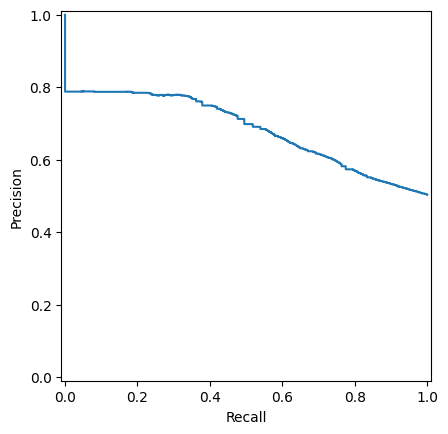

In [105]:
display = PrecisionRecallDisplay(recall=recall, precision=precision)
display.plot()

In [106]:
# finding the best threshold
pr_re[(pr_re.Recall > 0.70) & (pr_re.Precision > 0.60)]

,Threshold,Precision,Recall
1687,0.433028,0.600009,0.742720
1689,0.433153,0.600055,0.742606
1690,0.433192,0.600082,0.742606
1691,0.433199,0.600064,0.742550
1692,0.433207,0.600092,0.742550
...,...,...,...
2008,0.449852,0.616221,0.700397
2009,0.449912,0.616213,0.700283
2010,0.449995,0.616244,0.700283
2011,0.450020,0.616382,0.700057


In [107]:
pr_re[(pr_re.Recall > 0.70) & (pr_re.Precision > 0.60)].head(1)

,Threshold,Precision,Recall
1687,0.433028,0.600009,0.74272


#### The best threshold is `0.433028` with `0.74272` recall & `0.600009` precision 

### Final Model

In [123]:
model = RandomForestClassifier(criterion='gini', max_depth=3, min_samples_split=14, n_estimators=50, min_samples_leaf=9)

threshold = 0.433028

model.fit(X_train_preprocessed, y_train)

y_proba = model.predict_proba(X_test_preprocessed)
y_pred = (y_proba[:, 1] >= threshold).astype('int')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.50      0.57     21977
           1       0.60      0.74      0.66     21868

    accuracy                           0.62     43845
   macro avg       0.63      0.62      0.62     43845
weighted avg       0.63      0.62      0.62     43845



- The Model: Random Forest

- The Hyperparameters: criterion=gini, max_depth=3, min_samples_split=14, n_estimators=50, min_samples_leaf=9

- The Threshold: 0.421014

- The Recall: 0.74

- The Precision: 0.60

- The F1: 0.66

- The Accuracy: 0.62

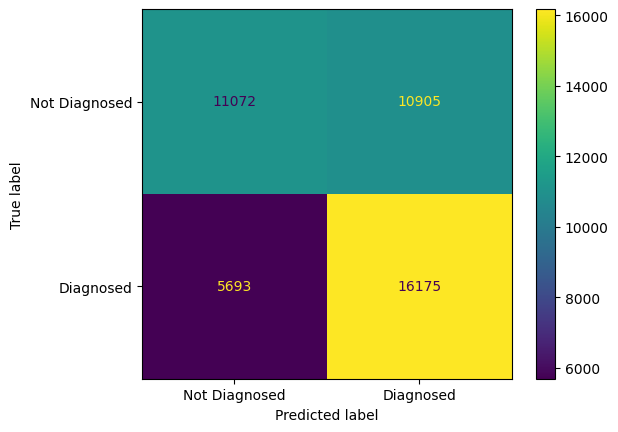

In [124]:
# confusion matrix
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Not Diagnosed', 'Diagnosed'])

confusion_matrix_display.plot()

## Saving

#### Saving The Preprocessor & threshold

In [125]:
pickle.dump([preprocessor, threshold], open('preprocessor_threshold.pkl', 'wb'))

#### Saving The Model

In [126]:
pickle.dump(model, open('model.pkl', 'wb'))

---